Loading data...
Processing data...
Calculating detailed daily stats...
Creating detailed report...
Detailed report saved to: D:\chrome_download\transaction_report_2025-06-25.csv
Creating visualization...
Chart saved to: D:\chrome_download\transaction_analysis_2025-06-25.png

Processing completed in 34.69 seconds
Processed 874,142 transactions from 2025-06-27 to 2025-07-28


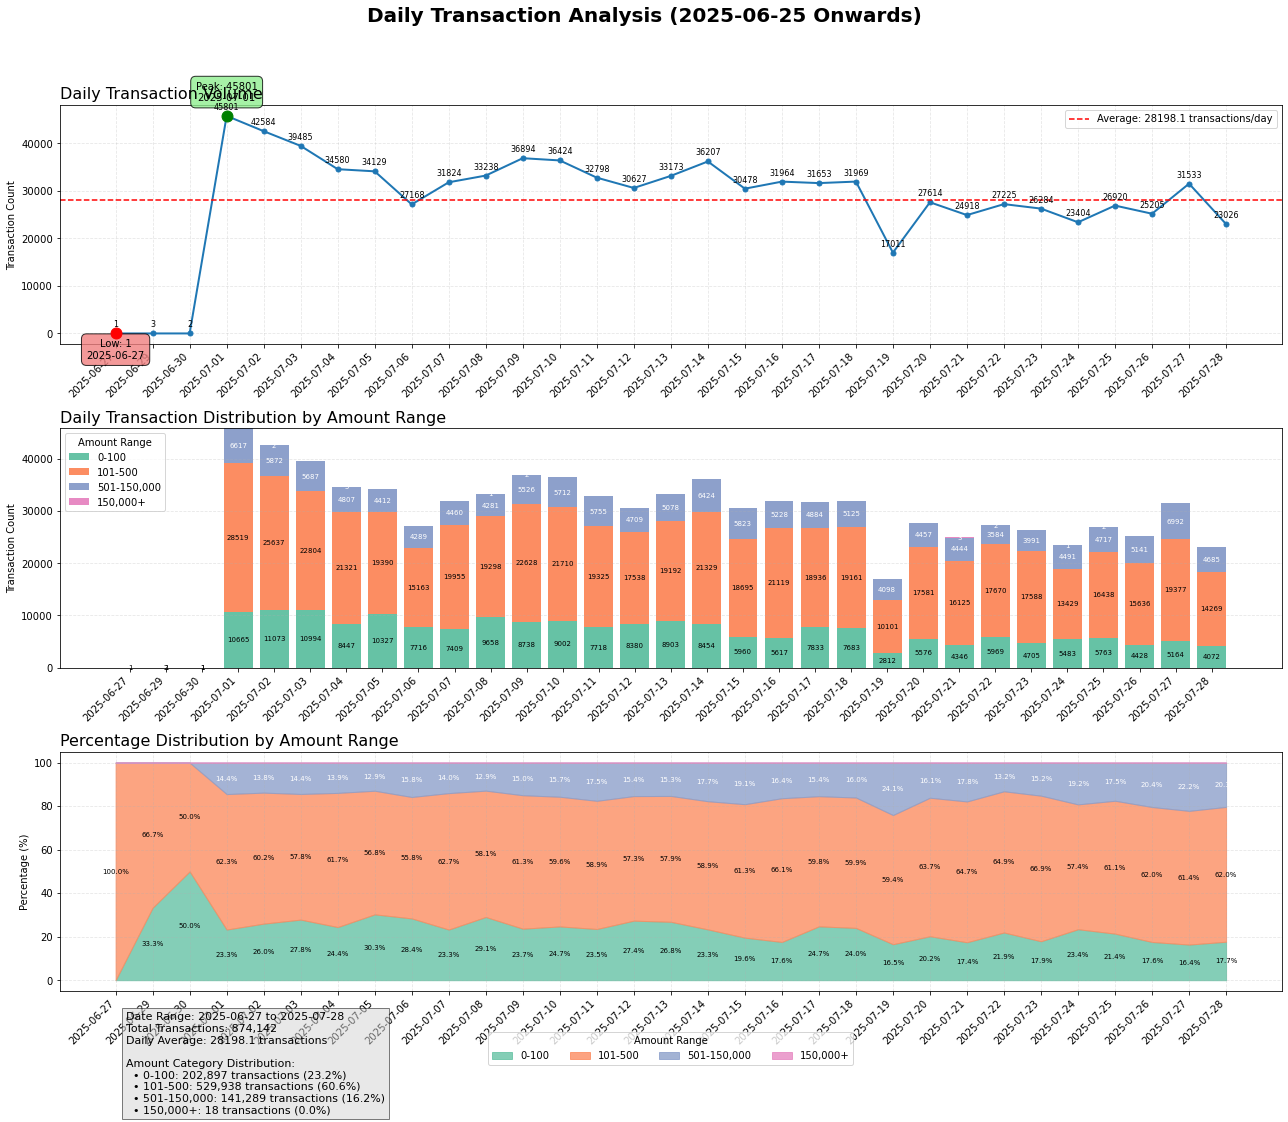

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
import os
import sys
from datetime import datetime

# Configuration
DATA_PATH = r"D:\chrome_download\1753689672161moore.csv"  # Update with your path
OUTPUT_DIR = os.path.dirname(DATA_PATH)
START_DATE = '2025-06-25'  # Your specified start date

# Amount categories configuration
AMOUNT_BINS = [0, 100, 500, 150000, float('inf')]
AMOUNT_LABELS = ['0-100', '101-500', '501-150,000', '150,000+']
COLORS = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

def main():
    start_time = time.time()
    
    try:
        # 1. Load data
        print("Loading data...")
        df = pd.read_csv(
            DATA_PATH,
            usecols=['trade_date', 'amount'],
            dtype={'amount': float}
        )
        
        # 2. Preprocess data
        print("Processing data...")
        # Convert to datetime and filter
        df['date'] = pd.to_datetime(df['trade_date'])
        df = df[df['date'] >= START_DATE]
        
        if df.empty:
            print(f"No data found after {START_DATE}")
            return
        
        # Convert back to string for consistent handling
        df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')
        
        # Create amount categories
        conditions = [
            df['amount'] <= 100,
            (df['amount'] > 100) & (df['amount'] <= 500),
            (df['amount'] > 500) & (df['amount'] <= 150000),
            df['amount'] > 150000
        ]
        df['amount_category'] = np.select(conditions, AMOUNT_LABELS, default='other')
        
        # 3. Prepare detailed daily statistics
        print("Calculating detailed daily stats...")
        # Total transactions per day
        daily_total = df.groupby('date_str').size().reset_index(name='total_count')
        
        # Transactions by category per day
        category_counts = pd.crosstab(df['date_str'], df['amount_category'])
        
        # Ensure all categories are present
        for label in AMOUNT_LABELS:
            if label not in category_counts.columns:
                category_counts[label] = 0
        
        # Merge results
        daily_stats = daily_total.merge(category_counts[AMOUNT_LABELS], 
                                       left_on='date_str', 
                                       right_index=True,
                                       how='left')
        
        # Fill any missing values
        daily_stats.fillna(0, inplace=True)
        daily_stats.sort_values('date_str', inplace=True)
        
        # Calculate percentages for each category
        for label in AMOUNT_LABELS:
            daily_stats[f'pct_{label}'] = (daily_stats[label] / daily_stats['total_count']) * 100
        
        # 4. Create detailed report CSV
        print("Creating detailed report...")
        detailed_report = pd.DataFrame()
        detailed_report['Date'] = daily_stats['date_str']
        detailed_report['Total Transactions'] = daily_stats['total_count']
        
        # Add count and percentage for each category
        detailed_report['0-100 Count'] = daily_stats['0-100']
        detailed_report['0-100 Percentage'] = daily_stats['pct_0-100'].round(2)
        
        detailed_report['101-500 Count'] = daily_stats['101-500']
        detailed_report['101-500 Percentage'] = daily_stats['pct_101-500'].round(2)
        
        detailed_report['501-150,000 Count'] = daily_stats['501-150,000']
        detailed_report['501-150,000 Percentage'] = daily_stats['pct_501-150,000'].round(2)
        
        detailed_report['>150,000 Count'] = daily_stats['150,000+']
        detailed_report['>150,000 Percentage'] = daily_stats['pct_150,000+'].round(2)
        
        # Save CSV report
        csv_path = os.path.join(OUTPUT_DIR, f"transaction_report_{START_DATE}.csv")
        detailed_report.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"Detailed report saved to: {csv_path}")
        
        # 5. Create visualization with English labels
        print("Creating visualization...")
        plt.figure(figsize=(18, 16))
        plt.suptitle(f'Daily Transaction Analysis ({START_DATE} Onwards)', 
                    fontsize=20, 
                    fontweight='bold')
        
        # Prepare x-axis positions
        dates = daily_stats['date_str'].tolist()
        x = np.arange(len(dates))
        
        # 5.1 Total Transactions Plot
        ax1 = plt.subplot(3, 1, 1)
        plt.plot(x, daily_stats['total_count'], 
                 marker='o', markersize=5, linestyle='-', linewidth=2, 
                 color='#1f77b4')
        
        # Find min/max values
        max_idx = daily_stats['total_count'].idxmax()
        min_idx = daily_stats['total_count'].idxmin()
        
        # Highlight min/max
        plt.scatter(x[max_idx], daily_stats.loc[max_idx, 'total_count'], 
                    color='green', s=120, zorder=5)
        plt.scatter(x[min_idx], daily_stats.loc[min_idx, 'total_count'], 
                    color='red', s=120, zorder=5)
        
        # Add annotations
        plt.annotate(f"Peak: {daily_stats.loc[max_idx, 'total_count']}\n{dates[max_idx]}", 
                    (x[max_idx], daily_stats.loc[max_idx, 'total_count']),
                    xytext=(0, 15), textcoords='offset points', 
                    ha='center', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.8))
        
        plt.annotate(f"Low: {daily_stats.loc[min_idx, 'total_count']}\n{dates[min_idx]}", 
                    (x[min_idx], daily_stats.loc[min_idx, 'total_count']),
                    xytext=(0, -25), textcoords='offset points', 
                    ha='center', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.5', fc='lightcoral', alpha=0.8))
        
        # Add daily counts on points
        for i, count in enumerate(daily_stats['total_count']):
            plt.text(x[i], count + max(daily_stats['total_count']) * 0.02, 
                     f"{int(count)}", 
                     ha='center', va='bottom', fontsize=8)
        
        # Add average line
        avg_count = daily_stats['total_count'].mean()
        plt.axhline(y=avg_count, color='r', linestyle='--', 
                   label=f'Average: {avg_count:.1f} transactions/day')
        
        plt.title('Daily Transaction Volume',loc='left' , fontsize=16)
        plt.ylabel('Transaction Count')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.legend()
        
        # Set x-axis labels with optimized spacing
        plt.xticks(x, dates, rotation=45, ha='right')
        n = len(dates)
        skip = max(1, n // 30)  # Show every nth label
        for i, label in enumerate(ax1.get_xticklabels()):
            if i % skip != 0:
                label.set_visible(False)
        
        # 5.2 Transaction Distribution by Amount (Stacked Bar Chart)
        ax2 = plt.subplot(3, 1, 2)
        stack_data = daily_stats[AMOUNT_LABELS]
        
        # Create stacked bar chart
        bottom = np.zeros(len(stack_data))
        for i, label in enumerate(AMOUNT_LABELS):
            ax2.bar(
                x, 
                stack_data[label], 
                bottom=bottom, 
                color=COLORS[i], 
                width=0.8,
                label=label
            )
            
            # Add count labels for each segment
            for j, val in enumerate(stack_data[label]):
                if val > 0:  # Only add label if value is non-zero
                    ax2.text(
                        x[j], 
                        bottom[j] + val/2, 
                        f"{int(val)}", 
                        ha='center', 
                        va='center',
                        fontsize=7,
                        color='white' if i in [2, 3] else 'black'
                    )
            
            bottom += stack_data[label]
        
        plt.title('Daily Transaction Distribution by Amount Range', loc='left' , fontsize=16)
        plt.ylabel('Transaction Count')
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')
        plt.legend(title='Amount Range', loc='upper left')
        
        # Set x-axis labels
        plt.xticks(x, dates, rotation=45, ha='right')
        for i, label in enumerate(ax2.get_xticklabels()):
            if i % skip != 0:
                label.set_visible(False)
        
        # 5.3 Percentage Distribution (Stacked Area Chart)
        ax3 = plt.subplot(3, 1, 3)
        percent_data = stack_data.div(stack_data.sum(axis=1), axis=0) * 100
        
        # Create stacked area chart
        bottom = np.zeros(len(percent_data))
        for i, label in enumerate(AMOUNT_LABELS):
            ax3.fill_between(
                x, 
                bottom, 
                bottom + percent_data[label],
                color=COLORS[i],
                alpha=0.8,
                label=label
            )
            
            # Add percentage labels at midpoints
            midpoints = bottom + percent_data[label]/2
            for j, val in enumerate(percent_data[label]):
                if val > 5:  # Only show label if percentage > 5%
                    ax3.text(
                        x[j], 
                        midpoints[j], 
                        f"{val:.1f}%", 
                        ha='center', 
                        va='center',
                        fontsize=7,
                        color='white' if i in [2, 3] else 'black'
                    )
            
            bottom += percent_data[label]
        
        plt.title('Percentage Distribution by Amount Range',loc='left' , fontsize=16)
        plt.ylabel('Percentage (%)')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.legend(title='Amount Range', loc='upper center', 
                  bbox_to_anchor=(0.5, -0.15), ncol=4)
        
        # Set x-axis labels
        plt.xticks(x, dates, rotation=45, ha='right')
        for i, label in enumerate(ax3.get_xticklabels()):
            if i % skip != 0:
                label.set_visible(False)
        
        # 6. Add summary statistics
        total_transactions = daily_stats['total_count'].sum()
        category_totals = stack_data.sum()
        category_percent = (category_totals / total_transactions) * 100
        
        stats_text = [
            f"Date Range: {min(dates)} to {max(dates)}",
            f"Total Transactions: {total_transactions:,}",
            f"Daily Average: {avg_count:.1f} transactions",
            "",
            "Amount Category Distribution:"
        ]
        
        for i, label in enumerate(AMOUNT_LABELS):
            stats_text.append(
                f"  • {label}: {category_totals.iloc[i]:,} transactions "
                f"({category_percent.iloc[i]:.1f}%)"
            )
        
        plt.figtext(0.1, 0.02, "\n".join(stats_text), 
                    ha='left', fontsize=11, 
                    bbox=dict(facecolor='lightgrey', alpha=0.5))
        
        # 7. Save visualization
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        
        output_image = os.path.join(OUTPUT_DIR, f"transaction_analysis_{START_DATE}.png")
        plt.savefig(output_image, dpi=150, bbox_inches='tight')
        print(f"Chart saved to: {output_image}")
        
        # 8. Performance metrics
        process_time = time.time() - start_time
        print(f"\nProcessing completed in {process_time:.2f} seconds")
        print(f"Processed {len(df):,} transactions from {min(dates)} to {max(dates)}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
        sys.exit(1)
if __name__ == "__main__":
    main()